# Depth To Basement Analysis and Prediction

This notebook aims at analysing the given dataset and building a machine learning model to predict the depth to basement rocks at a set location in the Gawler Craton in South Australia.

Table of contents:
1. <a href="#t1">Dataset detail</a>
2. <a href="#t2">Exploratory analysis on dataset</a>
3. <a href="#t3">Dimensionality reduction</a>
4. <a href="#t4">Features selection</a>
5. <a href="#t5">Model selection and tuning</a>

<h1 id="#t1">1. Data detail</h1>

There are some useful description to understand variables in the dataset provided by Department of State Development (SA 2018)
- SA_TMI is an unfiltered total magnetic intensity grid of South Australia, with an 80m grid cell size.
- SA_TMI_LP800 is a low pass filtered (800m, cut-off rate 1) TMI
- SA_TMI_VRTP is a variable reduction to pole (RTP) grid of SA_TMI generated by a Fast Fourier Transform (FFT) with IGRF field data: 01/01/1995; -30; 135, altitude 150m
- SA_TMI_LP800_VRTP is a low pass filtered (800m, cut-off rate 1) SA_TMI_VRTP
- SA_TMI_LP800_AS is a low pass filtered (800m, cut-off rate 1) Analytic Signal of SA_TMI. Analytic Signal is the square root of the sum of the squares of horizontal and vertical gradients. It is effective in mapping the distribution of shallow magnetisations independent of their magnetisation direction.
- SA_TMI_LP800_VRTP_1VDis the 1st Vertical Derivative of low pass filtered (800m, cut-off rate 1) Variable RTP of SA_TMI
- SA_TMI_LP800_1VD is the 1st Vertical Derivative of variable RTP of SA_TMI
- SA_TMI_VRTP_LP800_2VD is the 2nd Vertical Derivative of Low-pass filtered (800m, cut-off rate 1) Variable RTP of SA_TMI
- SA_TMI_VRTP_UC1000_Residual is the Upward Continued 1000m Residual of Variable RTP of SA_TMI
- SA_TMI_VRTP_PseudoGravity is the Pseudo Gravity of Variable RTP of SA_TMI. The ideal relationship between gravity and magnetic fields which would exist for an ideal relationship between density and magnetisation allows the prediction of gravity field variations from magnetic field measurements (Garland 1951, Baranov 1957, Bott and Ingles 1972). This is achieved by suitable transform of the magnetic field data, namely a reduction to pole and integration known as the pseudogravity transform.
- SA_TMI_VRTP_LP800_TILT is the Low pass filtered (800m cutoff, cut-off rate 1) VRTP TMI TILT Angle. The tilt angle is derived from the ratio of vertical and horizontal gradients transformed to an angle (range -90° to +90°) using the arc-tangent function (Miller and Singh, 1994). This ratio is independent of the magnitude of the gradients and is everywhere defined, which means that it is subject to noise across regions of low gradient.


<h1 id="t2">2. Exploratory analysis on dataset</h1>

In [1]:
# load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE

from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import random
random.seed(9001)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# this function will find highly correlated features, and return a list of features to remove
def find_correlation(data, threshold=0.7, remove_negative=True):
    corr_mat = data.corr()
    
    if remove_negative:
        corr_mat = np.abs(corr_mat)
        
    corr_mat.loc[:, :] = np.tril(corr_mat, k=-1)
    already_in = set()
    result = []
    
    for col in corr_mat:
        perfect_corr = corr_mat[col][corr_mat[col] > threshold].index.tolist()
        
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)
            
    select = [f[1:] for f in result]
    select_rmv = [i for j in select for i in j]
    
    return select_rmv

In [3]:
# loading dataset
df_train = pd.read_csv('./dataset.csv')
df_train.shape

(1777, 559)

Firstly, we are going to drop 2 variables that we won't use in this problem which are collar_id and geometry

In [4]:
# drop unused columns
df_train.drop(['collar_id', 'geometry'], axis=1, inplace=True)
df_train.describe()

,actual_depth,TMI_pointval,TMI_VRTP_pointval,TMI_VRTP_1VD_pointval,LP800_pointval,LP800_AS_pointval,LP800_VRTP_pointval,LP800_VRTP_1VD_pointval,LP800_VRTP_2VD_pointval,LP800_VRTP_TILT_pointval,...,TMI_VRTP_UC1000_ERS_mean_10kmradius,TMI_VRTP_UC1000_ERS_median_10kmradius,TMI_VRTP_UC1000_ERS_min_dist_10kmradius,TMI_VRTP_UC1000_ERS_max_dist_10kmradius,TMI_VRTP_UC1000_RES_ERS_max_10kmradius,TMI_VRTP_UC1000_RES_ERS_min_10kmradius,TMI_VRTP_UC1000_RES_ERS_mean_10kmradius,TMI_VRTP_UC1000_RES_ERS_median_10kmradius,TMI_VRTP_UC1000_RES_ERS_min_dist_10kmradius,TMI_VRTP_UC1000_RES_ERS_max_dist_10kmradius
count,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,...,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000,1777.000000
mean,69.302754,1687.130522,1496.937857,2.826523,1580.579458,4.778287,1379.449388,2.113701,0.007878,4.205969,...,252.775160,143.450159,4.792822,3.181210,6923.618083,-1743.155979,72.507169,-112.801124,3.295695,2.991505
std,179.466834,2491.383310,2565.935609,9.743628,2221.898970,6.580990,2220.332292,6.193750,0.034962,49.282645,...,524.189457,506.104647,0.563664,1.463565,7133.449460,1632.418103,128.413850,117.851575,1.426581,1.412295
min,0.000000,-3217.967773,-2362.703125,-26.451891,-2769.469482,0.011886,-1881.366089,-12.750922,-0.102143,-89.234795,...,-648.248535,-669.763794,0.665733,0.088034,-1.298752,-4733.615234,-329.631226,-604.719788,0.198413,0.039370
25%,5.999990,-34.723270,-194.316788,-0.348159,-5.389102,0.262473,-174.078201,-0.236484,-0.001355,-37.008110,...,-115.527306,-171.686844,4.920635,1.976259,1148.625488,-4158.440430,-16.451027,-206.375275,2.195130,1.843909
50%,16.000042,664.169373,476.148285,0.042266,656.428162,1.863767,478.986938,0.045813,0.000051,4.709424,...,223.972015,123.970085,4.975621,3.052133,3803.010254,-1131.951172,15.930841,-82.306976,3.760431,3.254210
75%,35.999996,3075.584961,2015.372925,2.712164,3009.926025,7.046042,2152.996582,2.051551,0.006886,49.873608,...,491.451294,237.058533,4.997480,4.906276,18058.507812,-270.212524,174.971710,-21.919397,4.464247,4.171714
max,1461.999974,14906.377930,15034.058594,64.118561,14420.828125,46.388653,13412.547852,41.334866,0.239495,88.946701,...,3415.360107,3618.369141,5.039683,5.039683,18058.507812,-20.079170,715.580383,485.390625,5.028756,5.034821


In [5]:
# check missing data
total = df_train.isnull().sum().sort_values(ascending=False)

# sort features by percentage of missing data in descending order
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
TMI_VRTP_UC1000_RES_ERS_max_dist_10kmradius,0,0.0
TMI_VRTP_PSDGRAV_ERS_median_2kmradius,0,0.0
TMI_VRTP_UC1000_ERS_median_2kmradius,0,0.0
TMI_VRTP_UC1000_ERS_mean_2kmradius,0,0.0
TMI_VRTP_UC1000_ERS_min_2kmradius,0,0.0
TMI_VRTP_UC1000_ERS_max_2kmradius,0,0.0
TMI_VRTP_PSDGRAV_ERS_max_dist_2kmradius,0,0.0
TMI_VRTP_PSDGRAV_ERS_min_dist_2kmradius,0,0.0
TMI_VRTP_PSDGRAV_ERS_mean_2kmradius,0,0.0
GRAV_1VD_max_2kmradius,0,0.0


We can see that this is a dataset which has very high dimensionality but a small number of data points (around 1777 rows). And there is no missing data in this dataset.

### 2.1 Univariate analysis

Now, we will take a look at how the actual_depth is distributed

count    1777.000000
mean       69.302754
std       179.466834
min         0.000000
25%         5.999990
50%        16.000042
75%        35.999996
max      1461.999974
Name: actual_depth, dtype: float64


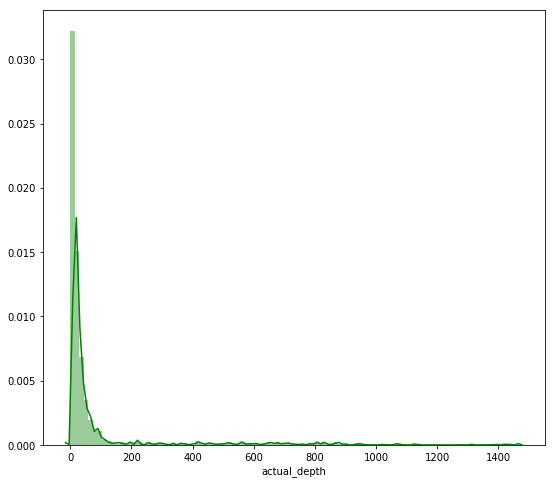

In [6]:
print(df_train['actual_depth'].describe())

plt.figure(figsize=(9, 8))
sns.distplot(df_train['actual_depth'], color='g', bins=100, hist_kws={'alpha': 0.4});

From the plot, we can see that actual_depth is right-skewed and most data is distributed between 0-200m. There are potentially some outliers which are higher than 1000m. Let's take a further analysis on this.

In [7]:
# standardizing data
scaled_depth = StandardScaler().fit_transform(df_train['actual_depth'][:,np.newaxis]);
low_range = scaled_depth[scaled_depth[:,0].argsort()][:10]
high_range= scaled_depth[scaled_depth[:,0].argsort()][-10:]

print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-0.38626782]
 [-0.38626782]
 [-0.38626782]
 [-0.38626782]
 [-0.38626782]
 [-0.38626782]
 [-0.38626782]
 [-0.38626782]
 [-0.38626782]
 [-0.38626782]]

outer range (high) of the distribution:
[[5.56050223]
 [5.56636505]
 [5.62767761]
 [5.88407493]
 [5.92865338]
 [6.92633322]
 [7.3666468 ]
 [7.56730089]
 [7.56730089]
 [7.76237715]]


- Low range values are similar and not too far from 0.
- High range values are far from 0 and the 7.something values are really out of range.

For now, we'll not consider any of these values as an outlier but we should be careful with those two 7.something values.

### 2.2 Bivariate analysis

#### Categorical variables

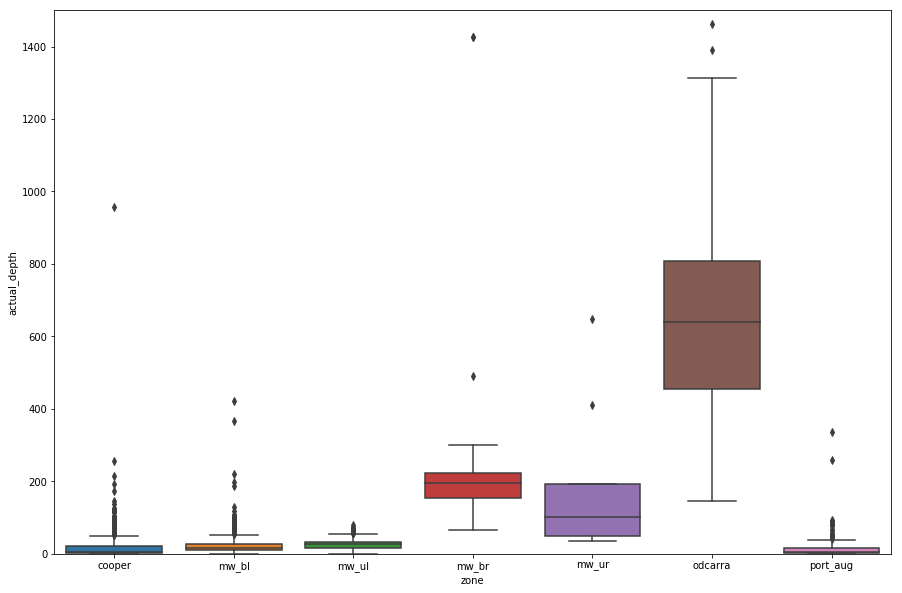

In [8]:
# box plot overallqual/saleprice
data = pd.concat([df_train['actual_depth'], df_train['zone']], axis=1)
f, ax = plt.subplots(figsize=(15, 10))
fig = sns.boxplot(x='zone', y="actual_depth", data=data)
fig.axis(ymin=0, ymax=1500);

The above plot shows the distribution of depth to basement in each region. While cooper, mw_bl, mw_ul and port_aug have similar distribution of depth values, adcarra has significantly higher figures, followed by mw_ur and mw_ur. 

Since 'zone' is the only categorical variable in the dataset, we will convert it to numeric.

In [9]:
lb_make = LabelEncoder()

zone_code = lb_make.fit_transform(df_train["zone"])

df_train["zone"] =zone_code

#### Numerical variables

Now we'll try to find which features are strongly correlated with actual_depth

In [10]:
# show 20 variables which have highest correlation with actual_depth
corrmat = df_train.corr()
k = 20
corrmat.nlargest(k, 'actual_depth')

,actual_depth,zone,TMI_pointval,TMI_VRTP_pointval,TMI_VRTP_1VD_pointval,LP800_pointval,LP800_AS_pointval,LP800_VRTP_pointval,LP800_VRTP_1VD_pointval,LP800_VRTP_2VD_pointval,...,TMI_VRTP_UC1000_ERS_mean_10kmradius,TMI_VRTP_UC1000_ERS_median_10kmradius,TMI_VRTP_UC1000_ERS_min_dist_10kmradius,TMI_VRTP_UC1000_ERS_max_dist_10kmradius,TMI_VRTP_UC1000_RES_ERS_max_10kmradius,TMI_VRTP_UC1000_RES_ERS_min_10kmradius,TMI_VRTP_UC1000_RES_ERS_mean_10kmradius,TMI_VRTP_UC1000_RES_ERS_median_10kmradius,TMI_VRTP_UC1000_RES_ERS_min_dist_10kmradius,TMI_VRTP_UC1000_RES_ERS_max_dist_10kmradius
actual_depth,1.000000,0.277780,-0.118077,-0.074180,-0.056040,-0.121711,-0.167661,-0.074823,-0.063051,-0.046254,...,0.058081,0.102976,-0.012090,0.152114,-0.230724,0.247983,-0.065241,0.236200,0.148403,0.057437
LP800_VRTP_TILT_min_2kmradius,0.601885,0.231715,-0.027910,0.055216,-0.025181,-0.020078,-0.125441,0.072581,-0.014931,-0.036297,...,0.155358,0.202586,0.086461,-0.042844,-0.154141,0.172350,0.085180,0.212975,0.166900,-0.032591
LP800_VRTP_TILT_min_4kmradius,0.512793,0.177950,-0.023510,0.006921,-0.040572,-0.018713,-0.101221,0.017828,-0.040631,-0.041231,...,0.121118,0.144198,0.069883,-0.057438,-0.111925,0.134254,0.092421,0.213983,0.150403,-0.031868
LP800_VRTP_TILT_min_1kmradius,0.442836,0.247459,0.131405,0.314656,0.211763,0.134739,0.025450,0.322971,0.258329,0.173940,...,0.224540,0.299887,0.095665,-0.038803,-0.129643,0.115109,0.074549,0.132315,0.186313,-0.067345
LP800_VRTP_TILT_min_6kmradius,0.411993,0.169585,-0.031850,0.009632,-0.023192,-0.030573,-0.085428,0.016119,-0.023710,-0.022748,...,0.125165,0.154587,0.043795,-0.030783,-0.125442,0.141053,0.074470,0.241359,0.117063,-0.043845
LP800_VRTP_TILT_min_8kmradius,0.349603,0.151494,-0.016681,0.023779,-0.016148,-0.014244,-0.065538,0.031068,-0.015207,-0.017305,...,0.129360,0.152481,0.035751,-0.035824,-0.100122,0.116332,0.092344,0.214857,0.101714,-0.042219
LP800_VRTP_min_4kmradius,0.310991,0.476119,-0.484632,-0.276472,-0.145681,-0.516968,-0.563968,-0.293963,-0.176033,-0.106242,...,0.083232,0.311232,0.014462,0.361032,-0.753947,0.771882,-0.293751,0.815744,0.328363,0.159098
TMI_VRTP_min_4kmradius,0.309609,0.447712,-0.502853,-0.323272,-0.180310,-0.532145,-0.618395,-0.340189,-0.215176,-0.136840,...,0.038062,0.265262,0.004821,0.355839,-0.769023,0.790255,-0.299375,0.805476,0.371558,0.199939
LP800_VRTP_min_6kmradius,0.308942,0.498385,-0.543829,-0.335678,-0.132586,-0.585658,-0.575703,-0.367510,-0.165714,-0.085868,...,-0.064832,0.162377,-0.005655,0.384231,-0.842892,0.865659,-0.446244,0.824510,0.248301,0.118803
TMI_VRTP_min_6kmradius,0.306681,0.461109,-0.564304,-0.366337,-0.147822,-0.605960,-0.605395,-0.399806,-0.185608,-0.098062,...,-0.093887,0.133564,-0.023841,0.404299,-0.856793,0.879443,-0.462014,0.823292,0.271183,0.139019


Only LP800_VRTP_TILT_min_2kmradius and LP800_VRTP_TILT_min_4kmradius have correlation values higher than 0.5 with actual_depth. We will plot these variables with actual_depth to see if we can get any insight from them.

In [11]:
# function to display scatter plot of a parituclar variable with actual_depth
def plot_scatter(var):
    data = pd.concat([df_train['actual_depth'], df_train[var]], axis=1)
    data.plot.scatter(x=var, y='actual_depth', ylim=(0,1500));

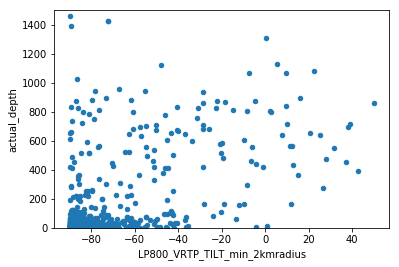

In [12]:
# scatter plot LP800_VRTP_TILT_min_2kmradius/actual_depth
plot_scatter('LP800_VRTP_TILT_min_2kmradius')

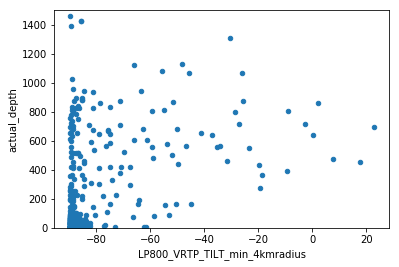

In [13]:
plot_scatter('LP800_VRTP_TILT_min_4kmradius')

In addition, we also want to plot some primary variables of this dataset

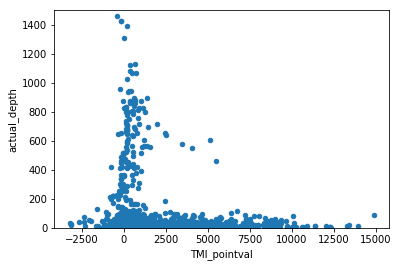

In [14]:
#scatter plot TMI_pointval/actual_depth
plot_scatter('TMI_pointval')

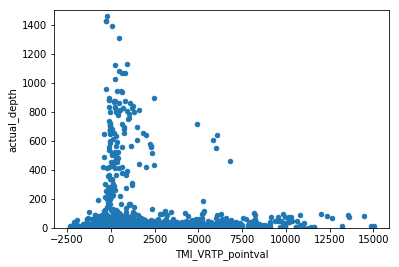

In [15]:
#scatter plot TMI_VRTP_pointval/actual_depth
plot_scatter('TMI_VRTP_pointval')

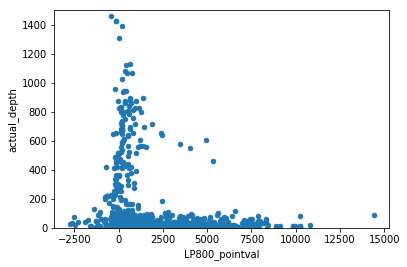

In [16]:
#scatter plot LP800_pointval/actual_depth
plot_scatter('LP800_pointval')

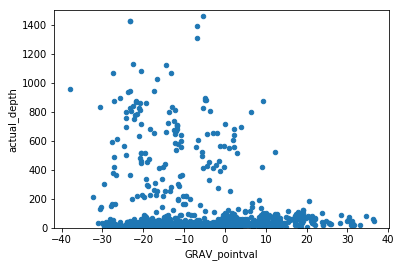

In [17]:
#scatter plot TMI_VRTP_UC1000_ERS_mean_10kmradius/actual_depth
plot_scatter('GRAV_pointval')

From all of the plots above, it is clear to see that there are 4 data points standing out from the crowd which we can consider to be outliers and remove them from the dataset.

In [18]:
# display rows which contain outliers
df_train.sort_values(by ='actual_depth', ascending = False)[:4].head()

,actual_depth,zone,TMI_pointval,TMI_VRTP_pointval,TMI_VRTP_1VD_pointval,LP800_pointval,LP800_AS_pointval,LP800_VRTP_pointval,LP800_VRTP_1VD_pointval,LP800_VRTP_2VD_pointval,...,TMI_VRTP_UC1000_ERS_mean_10kmradius,TMI_VRTP_UC1000_ERS_median_10kmradius,TMI_VRTP_UC1000_ERS_min_dist_10kmradius,TMI_VRTP_UC1000_ERS_max_dist_10kmradius,TMI_VRTP_UC1000_RES_ERS_max_10kmradius,TMI_VRTP_UC1000_RES_ERS_min_10kmradius,TMI_VRTP_UC1000_RES_ERS_mean_10kmradius,TMI_VRTP_UC1000_RES_ERS_median_10kmradius,TMI_VRTP_UC1000_RES_ERS_min_dist_10kmradius,TMI_VRTP_UC1000_RES_ERS_max_dist_10kmradius
1716,1461.999974,5,-417.815430,-205.927216,-0.255589,-417.495148,0.211159,-224.675064,-0.253736,-0.000116,...,231.276550,68.511681,3.926166,4.962661,1849.360840,-297.619324,-128.675537,-133.261963,3.400672,4.962661
1711,1427.000109,2,-126.485573,-307.469696,-0.027989,-126.674973,0.036804,-304.376343,-0.025334,0.000003,...,-280.608368,-276.252991,4.997480,4.972208,14.130203,-50.971802,-23.206839,-24.385300,4.967138,4.970307
1733,1427.000109,2,-126.485573,-307.469696,-0.027989,-126.674973,0.036804,-304.376343,-0.025334,0.000003,...,-280.608368,-276.252991,4.997480,4.972208,14.130203,-50.971802,-23.206839,-24.385300,4.967138,4.970307
255,1390.999488,5,209.213211,74.340508,-0.039396,209.325546,0.034009,77.526924,-0.039727,-0.000024,...,134.673584,116.798477,3.243100,4.964419,271.760681,-44.266060,1.486529,-12.253178,4.769962,4.967444


In [19]:
# delete outliers
df_train = df_train.drop([255, 1711, 1716, 1733], axis=0)
# reset index
df_train.reset_index(inplace=True, drop=True)
df_train.shape

(1773, 557)

<h3 id="t3">3. Feature selection and dimensionality reduction</h3>

#### 3.1 Low variance filter
We need to calculate the variance of each variable, then drop the variables having low variance as compared to other variables in our dataset. The reason for doing this is that variables with low variance do not tend to affect the target variable.

#### Data normalization
Firstly, we need to transform all features to the same range

In [20]:
# apply min max scaler to all variables
scaler = MinMaxScaler()

# df = df_train.select_dtypes(include=[np.number])
df_col = df_train.columns
df = scaler.fit_transform(df_train)

df = pd.DataFrame(data=df, columns=df_col)

Let's take a look at how variances are distributed

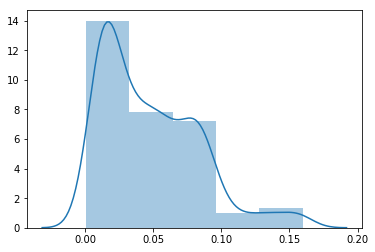

In [21]:
# plot distribution of variances
sns.distplot(df.var(), bins=5)

In [22]:
df.var().sort_values(ascending=True)

LP800_VRTP_TILT_max_10kmradius              0.000696
LP800_VRTP_TILT_max_8kmradius               0.000864
LP800_VRTP_TILT_min_10kmradius              0.001773
LP800_VRTP_TILT_max_6kmradius               0.001829
TMI_VRTP_UC1000_ERS_min_dist_2kmradius      0.003871
TMI_VRTP_PSDGRAV_ERS_min_dist_2kmradius     0.004174
LP800_VRTP_TILT_min_8kmradius               0.004199
LP800_VRTP_2VD_median_1kmradius             0.004802
LP800_VRTP_TILT_min_6kmradius               0.004892
LP800_VRTP_TILT_max_4kmradius               0.005244
LP800_VRTP_2VD_mean_6kmradius               0.005987
LP800_VRTP_AGC_mean_6kmradius               0.006021
LP800_VRTP_2VD_mean_4kmradius               0.006474
LP800_VRTP_AGC_mean_8kmradius               0.006487
LP800_VRTP_AGC_mean_4kmradius               0.006701
TMI_VRTP_1VD_median_2kmradius               0.006780
LP800_VRTP_TILT_min_4kmradius               0.006816
LP800_VRTP_2VD_mean_8kmradius               0.006966
GRAV_min_dist_2kmradius                     0.

According to the output above, except actual_depth that we need to keep, the variances of some of the features such as
'LP800_VRTP_TILT_max_10kmradius',
'LP800_VRTP_TILT_max_8kmradius',
'LP800_VRTP_TILT_min_10kmradius' and
'LP800_VRTP_TILT_max_6kmradius' are very little as compared to the other variables. We can safely drop these columns. So we are going to apply a low variance filter to remove some of these variables. But how much should the threshold be? Let's take a look at the distribution of variables' variances

In [23]:
df.var().sort_values(ascending=True).describe()

count    557.000000
mean       0.048004
std        0.035854
min        0.000696
25%        0.015991
50%        0.041224
75%        0.074590
max        0.159758
dtype: float64

We can see that 25% of scaled variables have variance less than 0.016 and 50% of them have variance less than 0.041. So it would be reasonable to set the threshold = 0.03

That means we are going to drop more than a quarter of the variables. That seems like a lot, but we still have a large number of variables remaining, which is considerably still very high dimensionality. So we need to reduce it further

In [24]:
var = df.var()
df = df.columns
# make sure we dont drop actual_depth
variable = ['actual_depth']

for i in range(1,len(var)):
    if var[i]>=0.03:
#         print(df[i])
        variable.append(df[i])
    
df_train = df_train[variable]
df_train.shape

(1773, 326)

### 3.2 High correlation filter

High correlation between two variables means they have similar trends and are likely to carry similar information. This can bring down the performance of some models drastically, especially in linear and logistic regression models. We can calculate the correlation between independent numerical variables that are numerical in nature. If the correlation coefficient crosses a certain threshold value, we can drop one of the variables.

As a general guideline, we should keep those variables which show a decent or high correlation with the target variable.

Let's look at those variables which have similar names

##### Variables'  name starting with 'TMI_'

In [25]:
# select those columns starting with TMI
TMI = df_train.filter(regex=("^TMI"))
TMI.shape

(1773, 124)

In [26]:
def plot_corrmat(df):
    #correlation matrix
    corrmat = df.corr()
    f, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(corrmat, vmax=.8, square=True);

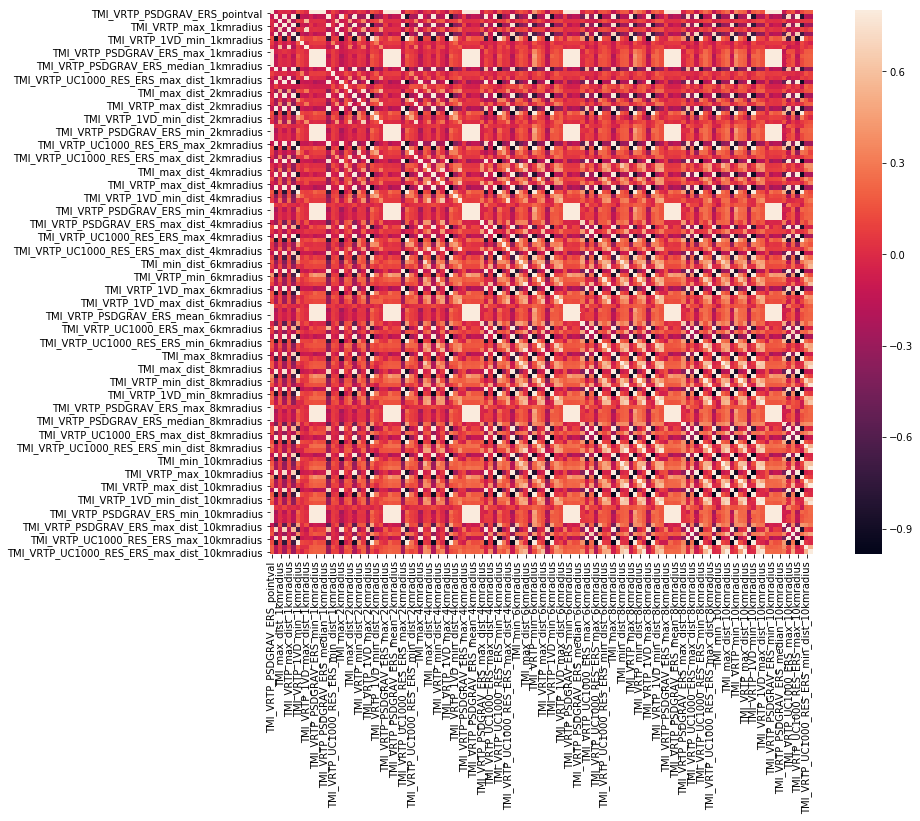

In [27]:
plot_corrmat(TMI)

It looks like there are many variables with significantly high correlation. And the similarity in their names can explain for that such as:
- 'TMI_VRTP_mean_1kmradius' & 'TMI_VRTP_median_1kmradius'
- 'TMI_VRTP_UC1000_RES_ERS_mean_10kmradius' & 'TMI_VRTP_UC1000_RES_ERS_median_10kmradius'
- 'TMI_VRTP_1VD_mean_1kmradius' & 'TMI_VRTP_1VD_median_1kmradius'

Generally, if the correlation between a pair of variables is greater than 0.7, we can seriously consider dropping one of those variables. Since we consider TMI_VRTP_pointval to be the 'absolute' readings, we are likely to keep this variable ad remove other variables that have high correlation with it

In [28]:
# drop variables with high correlation from TMI_VRTP
ls = set(find_correlation(TMI, threshold=0.7))
TMI = TMI.drop(list(ls), axis=1)
TMI.shape

(1773, 28)

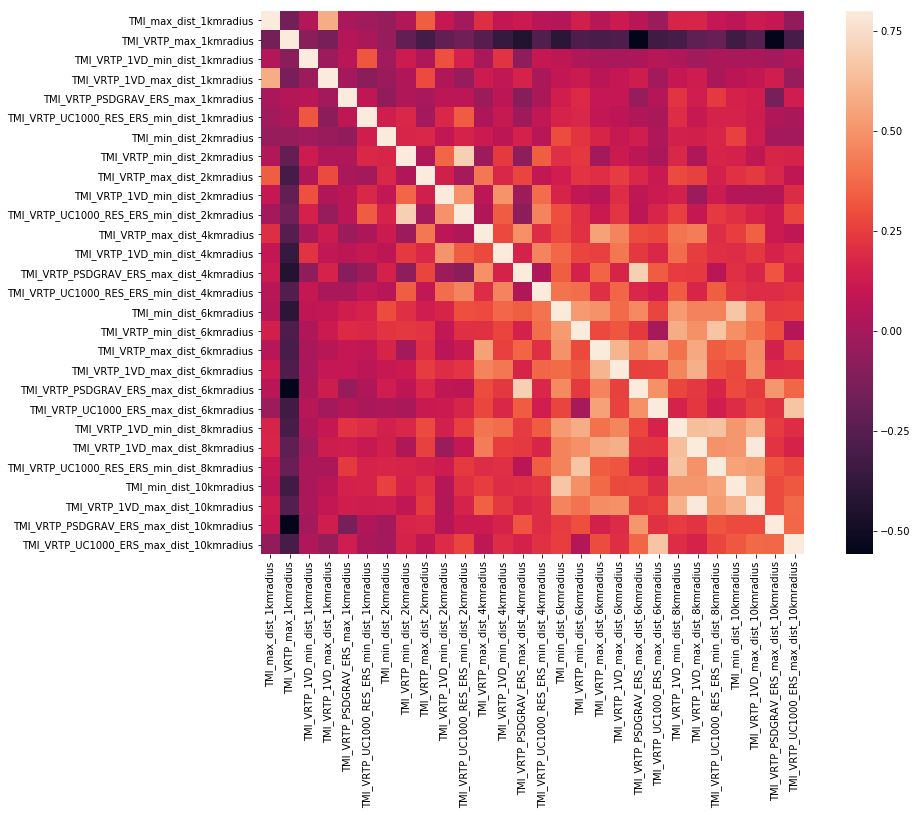

In [29]:
plot_corrmat(TMI)

We can see that highly correlated variables have been dropped from the dataframe

In [30]:
# drop those columns from orignal dataset as well
df_train = df_train.drop(list(ls), axis=1)

# there is still one more column we want to drop
df_train = df_train.drop('TMI_VRTP_1VD_max_dist_10kmradius', axis=1)
df_train.shape

(1773, 229)

#### Variables starting with 'LP800_'

In [31]:
# select those columns starting with LP800
LP800 = df_train.filter(regex=("^LP800"))
LP800.shape

(1773, 155)

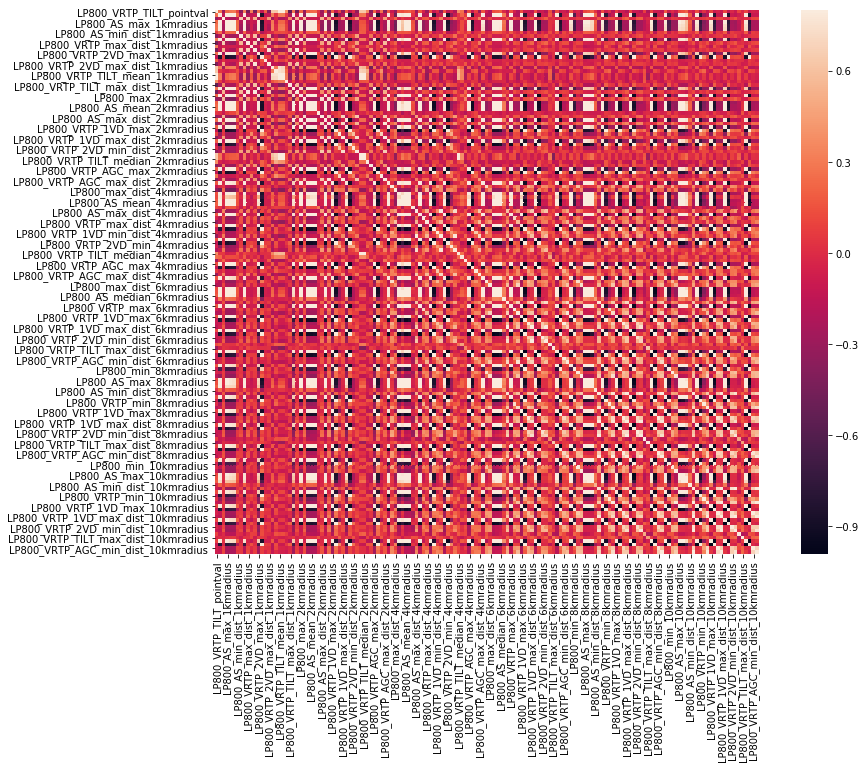

In [32]:
plot_corrmat(LP800)

Similarly, we have a lot of correlated variables here, so we want to drop them too

In [33]:
# drop variables with high correlation from LP800
ls = set(find_correlation(LP800, threshold=0.7))
LP800 = LP800.drop(list(ls), axis=1)
LP800.shape

(1773, 49)

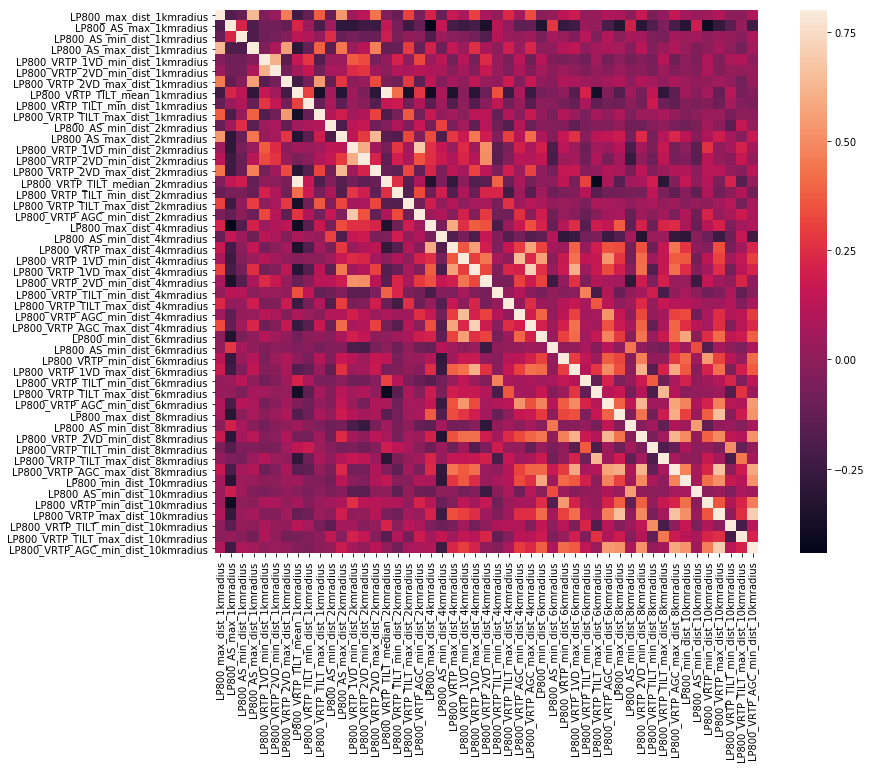

In [34]:
plot_corrmat(LP800)

In [35]:
# LP800.corr().sort_values(by='LP800_VRTP_TILT_mean_1kmradius', ascending=False)

In [36]:
# drop columns
df_train = df_train.drop(list(ls), axis=1)

# drop one more column which are still lef from above dataframe
df_train = df_train.drop('LP800_VRTP_TILT_mean_1kmradius', axis=1)
df_train.shape

(1773, 122)

##### Column names starting with 'GRAV_'

In [37]:
GRAV = df_train.filter(regex=("^GRAV"))
GRAV.shape

(1773, 45)

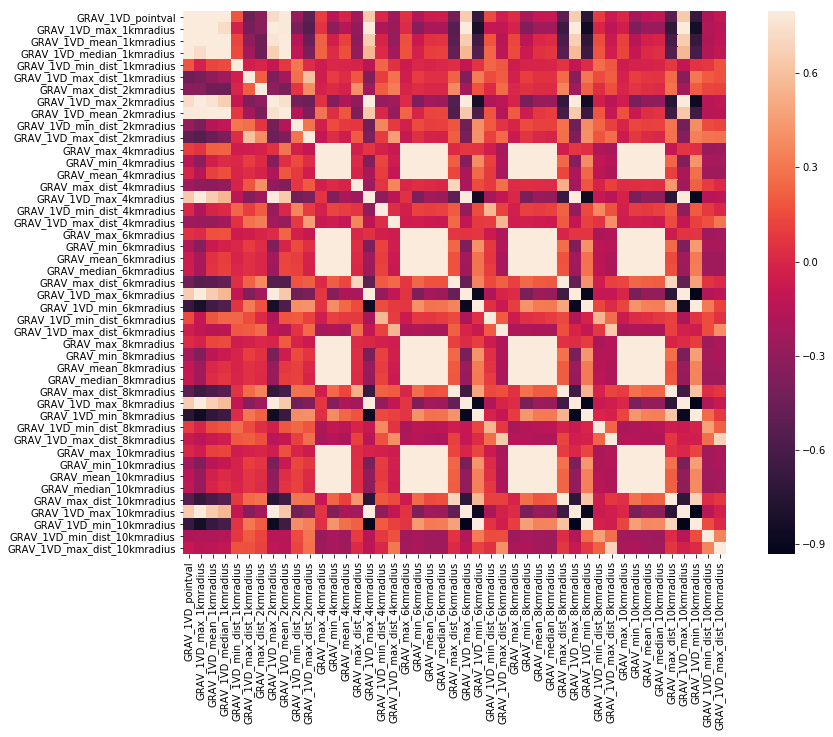

In [38]:
plot_corrmat(GRAV)

In [39]:
# drop variables with high correlation from LP800
ls = set(find_correlation(GRAV, threshold=0.7))
GRAV = GRAV.drop(list(ls), axis=1)
GRAV.shape

(1773, 18)

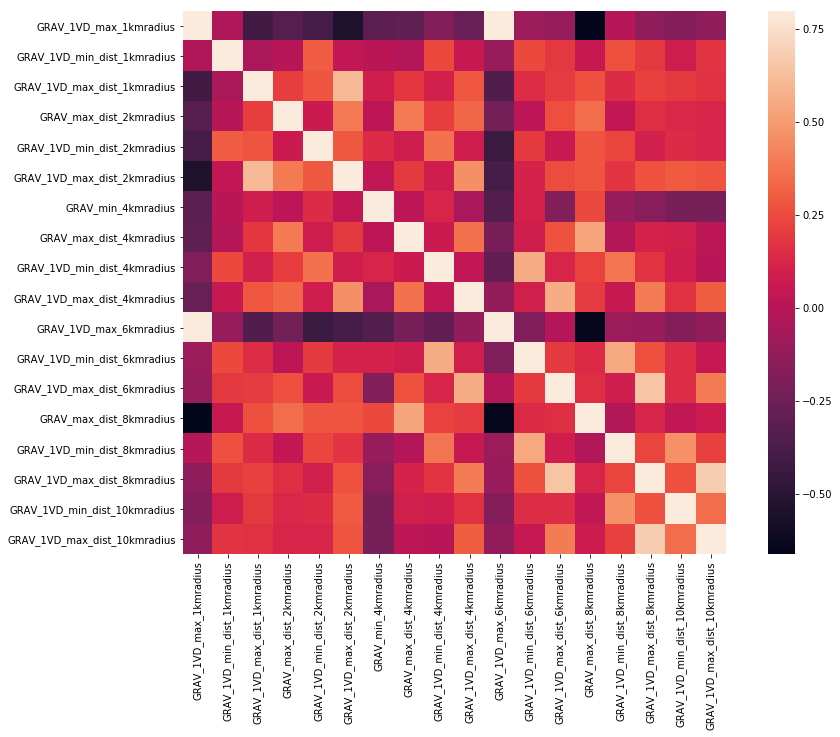

In [40]:
plot_corrmat(GRAV)

In [41]:
# drop columns
df_train = df_train.drop(list(ls), axis=1)

df_train = df_train.drop('GRAV_1VD_max_6kmradius', axis=1)
df_train.shape

(1773, 94)

##### One last filter to the big dataframe

In [42]:
ls = set(find_correlation(df_train, threshold=0.7))

# drop columns
df_train = df_train.drop(list(ls), axis=1)
df_train.shape

(1773, 79)

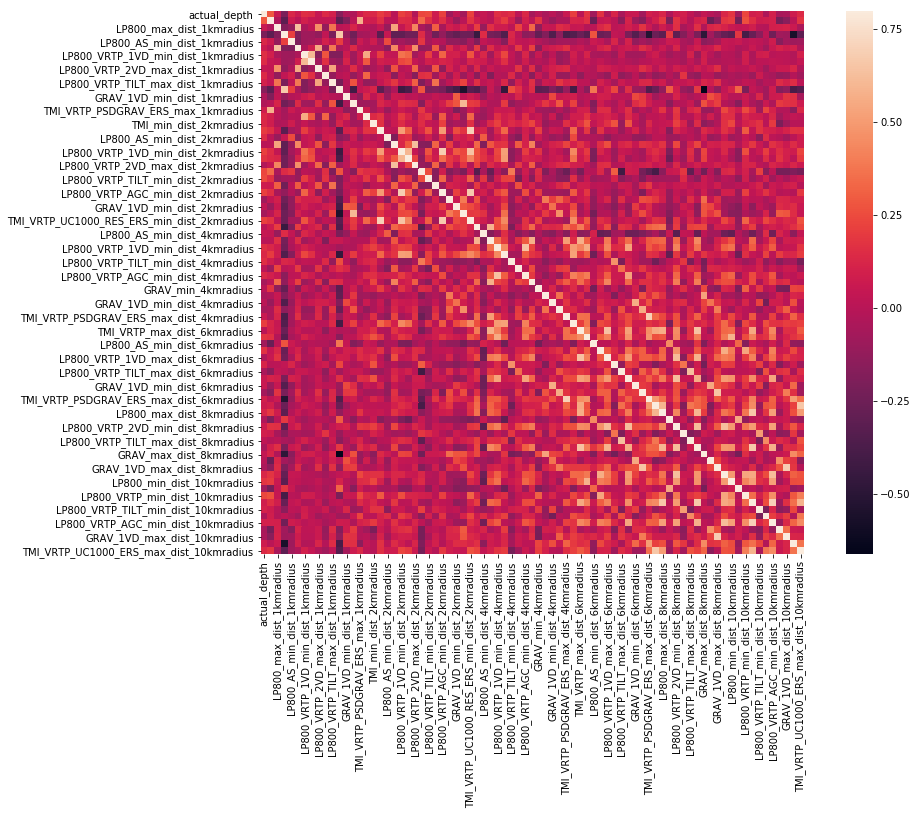

In [43]:
plot_corrmat(df_train)

<h1 id="t4">4. Features Selection</h1>

#### Principal Component Analysis
PCA is a technique which helps us in extracting a new set of variables from an existing large set of variables. These newly extracted variables are called Principal Components. Some of the key points we should know about PCA before proceeding further are as follows:
- A principal component is a linear combination of the original variables
- Principal components are extracted in such a way that the first principal component explains maximum variance in the dataset
- Second principal component tries to explain the remaining variance in the dataset and is uncorrelated to the first - principal component
- Third principal component tries to explain the variance which is not explained by the first two principal components and so on.

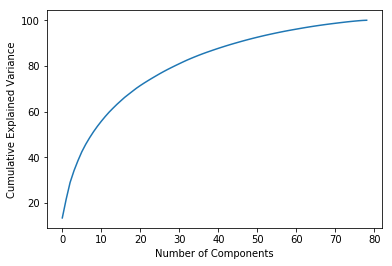

In [44]:
# pca = PCA(n_components=5)

df = scale(df_train)

# we let the algorithms decide the number of components
pca_result = PCA().fit(df)

#The amount of variance that each PC explains
var= pca_result.explained_variance_ratio_

# Cumulative Variance explains
var1 = np.cumsum(np.round(pca_result.explained_variance_ratio_, decimals=4)*100)

plt.plot(var1)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

We see that the more number of components are used, the more percentage of variance we can explain. That would lead us to believe that using these 79 components, we would recover most of the essential characteristics of the data. However, it does not make sense here since we want to reduce the dimension of the data. So PCA is not really a relevant method here.

#### Backward Feature Elimination / Recursive Feature Elimination (RFE)
Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached. This method can be used when building Linear Regression or Logistic Regression models.

In [45]:
# function stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 fe

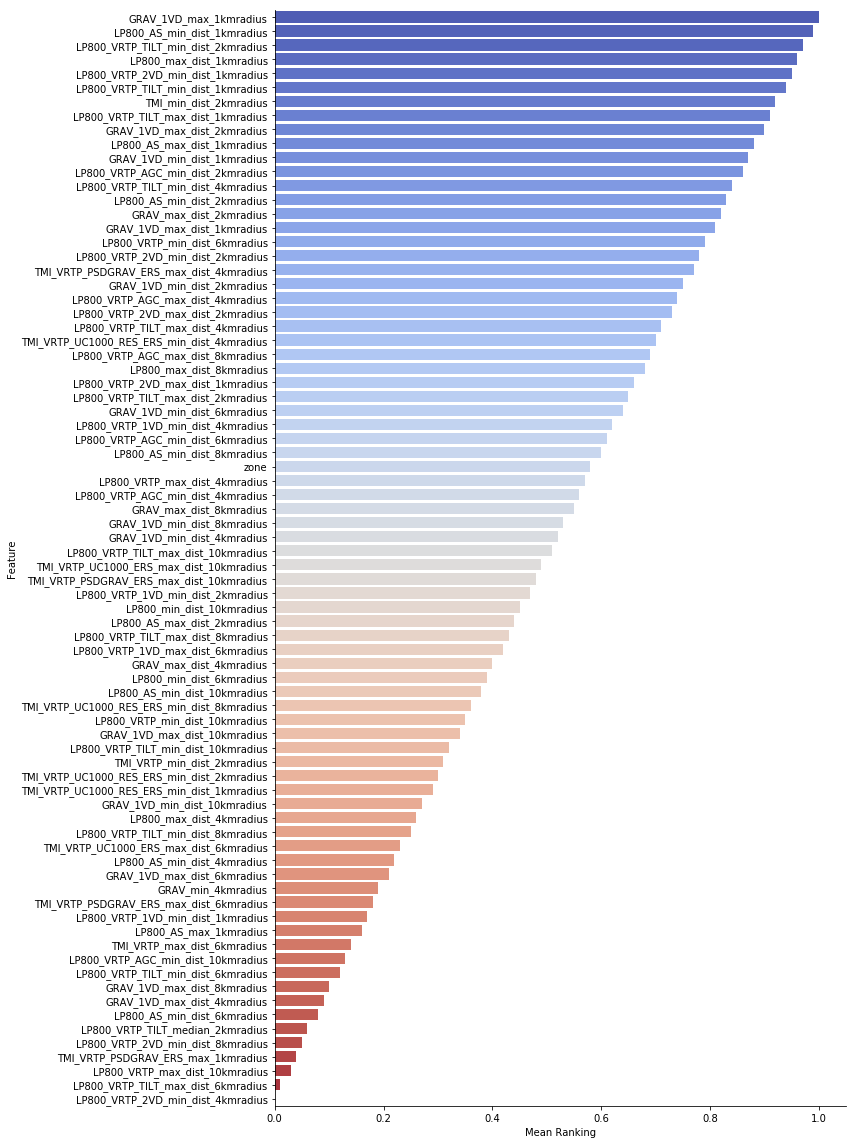

In [46]:
df = df_train.iloc[:,1:]

# Define dictionary to store our rankings
ranks = {}

lr = LinearRegression(normalize=True)
lr.fit(df, df_train.actual_depth)

#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(df, df_train.actual_depth)

ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), df.columns, order=-1)

# Create empty dictionary to store the mean value calculated from all the scores
r = {}

for name in df.columns:
    r[name] = round(np.mean([ranks[method][name] for method in ranks.keys()]), 2)
    
# Put the mean scores into a dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])
# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

# plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar",size=16, aspect=0.75, palette='coolwarm')

For now we will take all these features and evaluate them with a model in next part.

In [47]:
rfe_var = meanplot.iloc[:, 0]
rfe_var

10                        GRAV_1VD_max_1kmradius
3                    LP800_AS_min_dist_1kmradius
23            LP800_VRTP_TILT_min_dist_2kmradius
1                       LP800_max_dist_1kmradius
6              LP800_VRTP_2VD_min_dist_1kmradius
8             LP800_VRTP_TILT_min_dist_1kmradius
15                        TMI_min_dist_2kmradius
9             LP800_VRTP_TILT_max_dist_1kmradius
28                   GRAV_1VD_max_dist_2kmradius
4                    LP800_AS_max_dist_1kmradius
11                   GRAV_1VD_min_dist_1kmradius
25             LP800_VRTP_AGC_min_dist_2kmradius
35            LP800_VRTP_TILT_min_dist_4kmradius
17                   LP800_AS_min_dist_2kmradius
26                       GRAV_max_dist_2kmradius
12                   GRAV_1VD_max_dist_1kmradius
48                 LP800_VRTP_min_dist_6kmradius
20             LP800_VRTP_2VD_min_dist_2kmradius
43       TMI_VRTP_PSDGRAV_ERS_max_dist_4kmradius
27                   GRAV_1VD_min_dist_2kmradius
38             LP800

#### Forward Feature Selection

This is the opposite process of the Backward Feature Elimination we saw above. Instead of eliminating features, we try to find the best features which improve the performance of the model. This technique works as follows:

- We start with a single feature. Essentially, we train the model n number of times using each feature separately
- The variable giving the best performance is selected as the starting variable
- Then we repeat this process and add one variable at a time. The variable that produces the highest increase in performance is retained
- We repeat this process until no significant improvement is seen in the model’s performance

f_regression is used for testing the individual effect of each of many regressors. This is a scoring function to be used in a feature selection procedure, not a free standing feature selection procedure.

In [48]:
ffs = f_regression(df, df_train.actual_depth)

Selector_f = SelectPercentile(f_regression, percentile=25)
Selector_f.fit(df, df_train.actual_depth)

for n, s in zip(df.columns, Selector_f.scores_):
    print ("F-score: %3.2f for feature %s " % (s, n))

F-score: 159.71 for feature zone 
F-score: 7.16 for feature LP800_max_dist_1kmradius 
F-score: 76.79 for feature LP800_AS_max_1kmradius 
F-score: 28.77 for feature LP800_AS_min_dist_1kmradius 
F-score: 9.26 for feature LP800_AS_max_dist_1kmradius 
F-score: 45.31 for feature LP800_VRTP_1VD_min_dist_1kmradius 
F-score: 38.43 for feature LP800_VRTP_2VD_min_dist_1kmradius 
F-score: 4.62 for feature LP800_VRTP_2VD_max_dist_1kmradius 
F-score: 36.14 for feature LP800_VRTP_TILT_min_dist_1kmradius 
F-score: 17.93 for feature LP800_VRTP_TILT_max_dist_1kmradius 
F-score: 46.92 for feature GRAV_1VD_max_1kmradius 
F-score: 1.55 for feature GRAV_1VD_min_dist_1kmradius 
F-score: 0.91 for feature GRAV_1VD_max_dist_1kmradius 
F-score: 14.47 for feature TMI_VRTP_PSDGRAV_ERS_max_1kmradius 
F-score: 35.76 for feature TMI_VRTP_UC1000_RES_ERS_min_dist_1kmradius 
F-score: 34.08 for feature TMI_min_dist_2kmradius 
F-score: 76.83 for feature TMI_VRTP_min_dist_2kmradius 
F-score: 41.31 for feature LP800_AS_min

We will take all the ranked features and evaluate them with a machine learning model next part 

In [49]:
ffs = pd.DataFrame({'features':df.columns,"f_score":Selector_f.scores_})
ffs = ffs.sort_values(by="f_score", ascending=False)
ffs_var = ffs.features

#### Random Forest
Random Forest is one of the most widely used algorithms for feature selection. It comes packaged with in-built feature importance so we don’t need to program that separately. This helps us select a smaller subset of features.

In [50]:
model = RandomForestRegressor(n_estimators=200, random_state=1, bootstrap=True)

# df = pd.get_dummies(df_train)
# df = df.drop('actual_depth', 1)

model.fit(df, df_train.actual_depth)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

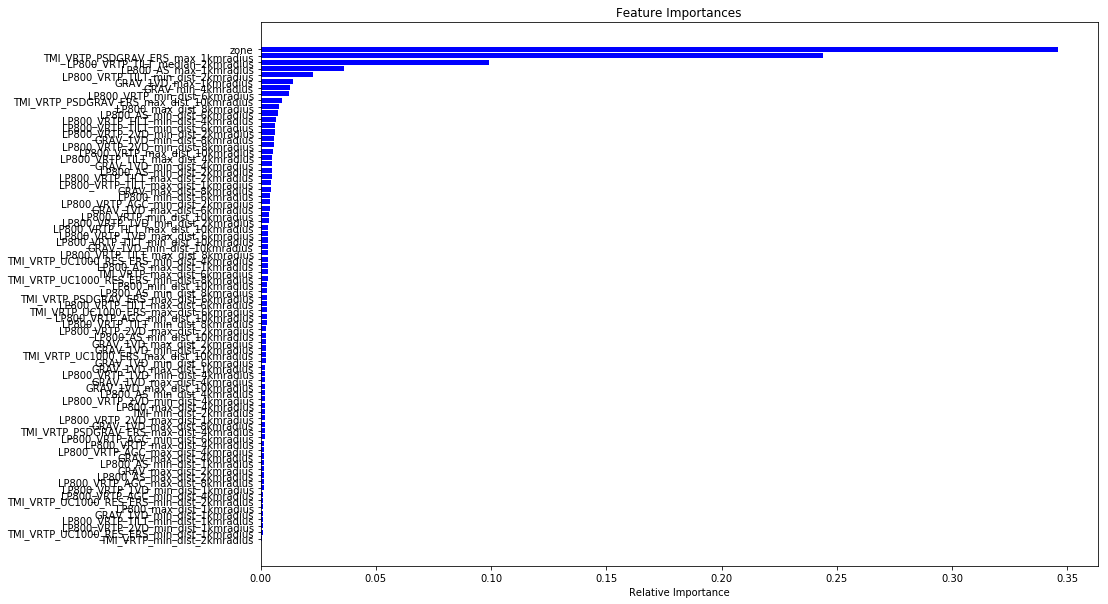

In [51]:
# top_feature = 40
features = df.columns

importances = model.feature_importances_
indices = np.argsort(importances[0:])

plt.figure(figsize=(15, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [52]:
idx = indices[-20:]
df.iloc[:,idx].columns

Index(['LP800_AS_min_dist_2kmradius', 'GRAV_1VD_min_dist_4kmradius',
       'LP800_VRTP_TILT_max_dist_4kmradius', 'LP800_VRTP_max_dist_10kmradius',
       'LP800_VRTP_2VD_min_dist_8kmradius', 'GRAV_1VD_min_dist_8kmradius',
       'LP800_VRTP_2VD_min_dist_2kmradius',
       'LP800_VRTP_TILT_min_dist_6kmradius',
       'LP800_VRTP_TILT_min_dist_4kmradius', 'LP800_AS_min_dist_6kmradius',
       'LP800_max_dist_8kmradius', 'TMI_VRTP_PSDGRAV_ERS_max_dist_10kmradius',
       'LP800_VRTP_min_dist_6kmradius', 'GRAV_min_4kmradius',
       'GRAV_1VD_max_1kmradius', 'LP800_VRTP_TILT_min_dist_2kmradius',
       'LP800_AS_max_1kmradius', 'LP800_VRTP_TILT_median_2kmradius',
       'TMI_VRTP_PSDGRAV_ERS_max_1kmradius', 'zone'],
      dtype='object')

Based on the above graph, we can hand pick the top-most features to reduce the dimensionality in our dataset. Alernatively, we can use the SelectFromModel of sklearn to do so. It selects the features based on the importance of their weights.

In [53]:
feature = SelectFromModel(model, threshold=0.001)

fit = feature.fit(df, df_train.actual_depth)

n_features = fit.transform(df).shape[1]

n_features

76

At this step, we may set a low threshold to take as many features as we can because we will filter them out in the next part.

<h1 id="t5">5. Model selection</h1>

Firstly, we need to find a good approach for validation. There are two common cross validation methodologies: holdout cross validation and k-fold cross validation. The first approach requires the dataset to be divided into 3 parts in order to train a model on a training set (60% of the data), then perform model selection (tuning parameters) on validation set (20% of the data) and test the model on the test set (20% of the data). However, since the current dataset is just a small sample of data which includes 1773 records, it is better to implement K-Fold cross validation in this case.

After that, we try to fit the dataset with all features on different models to compare their performance. Then we will take the best model to test it on different set of variables and tune parameters to achieve an optimized solution.

In [54]:
# x_train = df_train.iloc[:,1:]
# y_train = df_train['actual_depth']

In [55]:
# normalize data before feeding to the models
x_col = df_train.columns

x_train = StandardScaler().fit_transform(df_train)
x_train = pd.DataFrame(data=x_train, columns=x_col)

y_train = x_train["actual_depth"]
x_train = x_train.iloc[:,1:]

AdaBoost --> mean squared error: 0.691230 (std: 0.266546)
GradientBoost --> mean squared error: 0.253474 (std: 0.374757)
RandomForest --> mean squared error: 0.422358 (std: 0.717393)
ExtraTrees --> mean squared error: 0.235022 (std: 0.365811)
BaggingReg --> mean squared error: 0.385946 (std: 0.629115)
DecisionTree --> mean squared error: 0.488259 (std: 0.642183)
LinearReg --> mean squared error: 0.928686 (std: 0.927824)
ElasticNet --> mean squared error: 0.906470 (std: 0.985273)


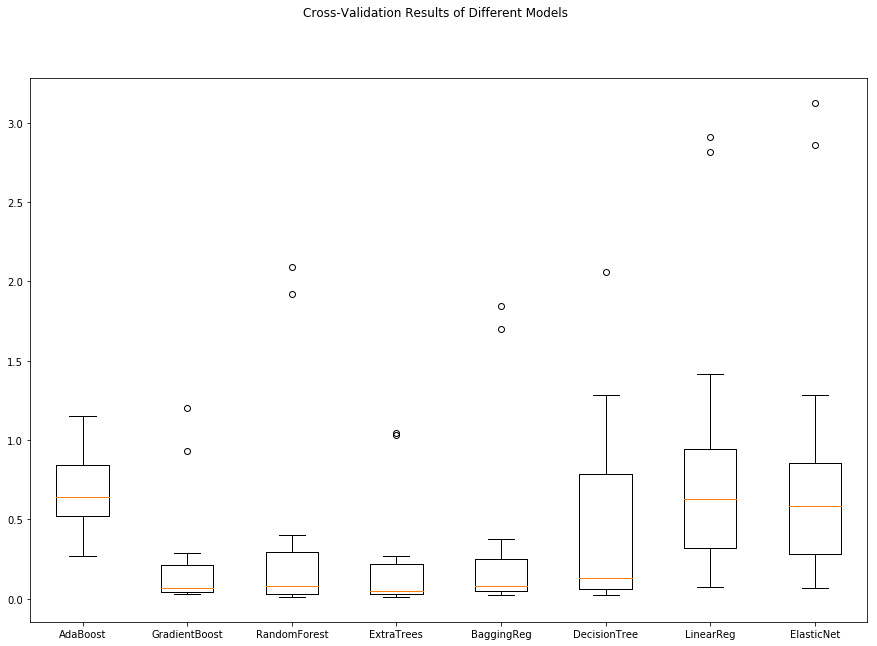

In [56]:
num_folds = 12
seed = 123
scoring = 'mean_squared_error'

models = []

# ensemble models
models.append(('AdaBoost', AdaBoostRegressor(n_estimators=100, random_state=10)))
models.append(('GradientBoost', GradientBoostingRegressor(n_estimators=100, random_state=10)))
models.append(('RandomForest', RandomForestRegressor(n_estimators=100, random_state=10, bootstrap=True)))
models.append(('ExtraTrees', ExtraTreesRegressor(n_estimators=100, random_state=10, bootstrap=True)))
models.append(('BaggingReg', BaggingRegressor(n_estimators=100, random_state=10, bootstrap=True, bootstrap_features=True)))
# tree model
models.append(('DecisionTree', DecisionTreeRegressor(random_state=10)))
# linear models 
models.append(("LinearReg", LinearRegression()))
models.append(("ElasticNet", ElasticNet(alpha=0.01)))

results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, x_train, y_train, cv=num_folds, scoring=scoring)
    results.append([-re for re in cv_results])
    names.append(name)
    
    msg = "%s --> mean squared error: %f (std: %f)" % (name, -cv_results.mean(), cv_results.std())
    
    print(msg)

# Compare Algorithms
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Cross-Validation Results of Different Models')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show();

Using mean squared error to measure models' performance, we can see that Extra Trees regressor has the best performance on this kind of dataset with the lowest mse score. So we will pick this algorithm to tune the parameters and fit it with different combinations of features to evaluate it's performance.

This time we will use repeated K-fold cross validation with increasing number of important features to evaluate which number of variables is optimal for Extra Tree Regressor

In [57]:
# print(rfe_var.index)
# ffs_var.index

In [58]:
set_cv = 12
model = ExtraTreesRegressor(n_estimators=100, random_state=10, bootstrap=True)
scoring = 'mean_squared_error'

repeat_kfold = 5
fea_num = [10, 20, 30, 40, 50, 60, 70, 78]

Evaluate performance of variabel selected by RFE method on the chosen model

In [59]:
rfe_results = []
rfe_compo = []

for num in fea_num:
    small_x_train = x_train[rfe_var[0:num]]
    nested_result = []
    
    for k in range(repeat_kfold):
        # shuffle dataset 
        train_df = pd.concat([small_x_train, y_train], axis=1, sort=False)
        train_df = shuffle(train_df)
        new_y = train_df['actual_depth']
        new_x = train_df.drop('actual_depth', axis=1)
        
        cv_results = cross_val_score(model, new_x, new_y, cv=set_cv, scoring=scoring)
#         print(cv_results)
        nested_result.append(-cv_results.mean())
        
        msg = "(k: %f -- features: %f) --> mean squared error: %f" % (k, num, -cv_results.mean())
        print(msg)
    
    rfe_results.append(sum(nested_result) / len(nested_result))
    rfe_compo.append(num)

(k: 0.000000 -- features: 10.000000) --> mean squared error: 0.598079
(k: 1.000000 -- features: 10.000000) --> mean squared error: 0.612986
(k: 2.000000 -- features: 10.000000) --> mean squared error: 0.609219
(k: 3.000000 -- features: 10.000000) --> mean squared error: 0.601076
(k: 4.000000 -- features: 10.000000) --> mean squared error: 0.603089
(k: 0.000000 -- features: 20.000000) --> mean squared error: 0.512297
(k: 1.000000 -- features: 20.000000) --> mean squared error: 0.519427
(k: 2.000000 -- features: 20.000000) --> mean squared error: 0.504385
(k: 3.000000 -- features: 20.000000) --> mean squared error: 0.508033
(k: 4.000000 -- features: 20.000000) --> mean squared error: 0.501649
(k: 0.000000 -- features: 30.000000) --> mean squared error: 0.502854
(k: 1.000000 -- features: 30.000000) --> mean squared error: 0.498740
(k: 2.000000 -- features: 30.000000) --> mean squared error: 0.514585
(k: 3.000000 -- features: 30.000000) --> mean squared error: 0.493653
(k: 4.000000 -- feat

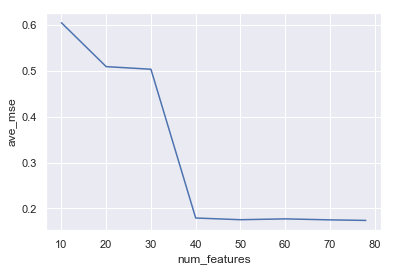

In [60]:
sns.set()
ax = sns.lineplot(x="num_features", y="ave_mse", data=pd.DataFrame({"num_features":rfe_compo, "ave_mse":rfe_results}))

Evaluate performance of variabel selected by FFS method on the chosen model

In [61]:
ffs_results = []
ffs_compo = []

for num in fea_num:
    small_x_train = x_train[ffs_var[0:num]]
    nested_result = []
    
    for k in range(repeat_kfold):
        train_df = pd.concat([small_x_train, y_train], axis=1, sort=False)
        train_df = shuffle(train_df)
        new_y = train_df['actual_depth']
        new_x = train_df.drop('actual_depth', axis=1)
        
        cv_results = cross_val_score(model, new_x, new_y, cv=set_cv, scoring=scoring)
#         print(cv_results)
        nested_result.append(-cv_results.mean())
        
        msg = "(k: %f -- features: %f) --> mean squared error: %f" % (k, num, -cv_results.mean())
        print(msg)
    
    ffs_results.append(sum(nested_result) / len(nested_result))
    ffs_compo.append(num)

(k: 0.000000 -- features: 10.000000) --> mean squared error: 0.193372
(k: 1.000000 -- features: 10.000000) --> mean squared error: 0.184138
(k: 2.000000 -- features: 10.000000) --> mean squared error: 0.179355
(k: 3.000000 -- features: 10.000000) --> mean squared error: 0.193693
(k: 4.000000 -- features: 10.000000) --> mean squared error: 0.192708
(k: 0.000000 -- features: 20.000000) --> mean squared error: 0.180070
(k: 1.000000 -- features: 20.000000) --> mean squared error: 0.181028
(k: 2.000000 -- features: 20.000000) --> mean squared error: 0.177981
(k: 3.000000 -- features: 20.000000) --> mean squared error: 0.175612
(k: 4.000000 -- features: 20.000000) --> mean squared error: 0.182217
(k: 0.000000 -- features: 30.000000) --> mean squared error: 0.183232
(k: 1.000000 -- features: 30.000000) --> mean squared error: 0.186255
(k: 2.000000 -- features: 30.000000) --> mean squared error: 0.175836
(k: 3.000000 -- features: 30.000000) --> mean squared error: 0.177965
(k: 4.000000 -- feat

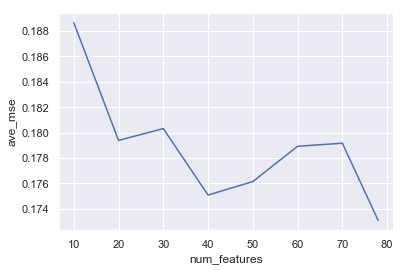

In [62]:
ax = sns.lineplot(x="num_features", y="ave_mse", data=pd.DataFrame({"num_features":ffs_compo, "ave_mse":ffs_results}))

In [63]:
print(rfe_results)
print(ffs_results)

[0.6048898190106154, 0.5091582506918825, 0.5034809559170527, 0.17896313926492, 0.17525363809731997, 0.17708139114806004, 0.17492021396055085, 0.17371221977928206]
[0.1886532886858817, 0.1793815082097488, 0.18031292778431468, 0.1750754796944643, 0.17613773792876777, 0.17891816123635804, 0.1791595023546677, 0.17307620160135323]


We can see the similarity between the two plots above as they both achieve a really low average sme with 40 features. Thus, this should be the optimal number of features for the model.

#### Tuning model
Finally, in order to find the best regression model, we are going to tune several parameters to see if we can improve the model a bit more. We continue to use repeated K-Fold validation to evaluate the models

In [64]:
best_n_feature = 40
scoring = 'mean_squared_error'
repeat_kfold = 5

# tuning parameters
# number of trees
estimators = [50, 100, 150, 200, 500, 1000]
# max numver of features to consider every split
max_features = ['auto', 'sqrt', 'log2']
# maximum numver of levels in tree
max_depth = [10, 20, 30, 40, 50]
# minimum number of samples required to split a node
min_sample_split = [2,5,10,15,20]
min_sample_leaf = [1,2,5,10,15]

##### 1. n_estimators
Random forest models are ensembles of decision trees and we can define the number of decision trees in the forest. Additional decision trees typically improve model accuracy because predictions are made based on a larger number of “votes” from diverse trees, however, large numbers of trees are computationally expensive.

<font color="red">The following code may take a long time to finish</font>

In [65]:
estimator_results = []
best_est = []

for num in estimators:
    model = ExtraTreesRegressor(n_estimators=num, random_state=10, bootstrap=True)
    
    small_x_train = x_train[rfe_var[0:best_n_feature]]
    nested_result = []
    
    for k in range(repeat_kfold):
        train_df = pd.concat([small_x_train, y_train], axis=1, sort=False)
        train_df = shuffle(train_df)
        new_y = train_df['actual_depth']
        new_x = train_df.drop('actual_depth', axis=1)
        
        cv_results = cross_val_score(model, new_x, new_y, cv=set_cv, scoring=scoring)
#         print(cv_results)
        nested_result.append(-cv_results.mean())
        
        msg = "(k: %f -- n_estimators: %f) --> mean squared error: %f" % (k, num, -cv_results.mean())
        print(msg)
    
    estimator_results.append(sum(nested_result) / len(nested_result))
    best_est.append(num)

(k: 0.000000 -- n_estimators: 50.000000) --> mean squared error: 0.173354
(k: 1.000000 -- n_estimators: 50.000000) --> mean squared error: 0.181909
(k: 2.000000 -- n_estimators: 50.000000) --> mean squared error: 0.181869
(k: 3.000000 -- n_estimators: 50.000000) --> mean squared error: 0.176211
(k: 4.000000 -- n_estimators: 50.000000) --> mean squared error: 0.179729
(k: 0.000000 -- n_estimators: 100.000000) --> mean squared error: 0.182476
(k: 1.000000 -- n_estimators: 100.000000) --> mean squared error: 0.179148
(k: 2.000000 -- n_estimators: 100.000000) --> mean squared error: 0.174554
(k: 3.000000 -- n_estimators: 100.000000) --> mean squared error: 0.176044
(k: 4.000000 -- n_estimators: 100.000000) --> mean squared error: 0.176211
(k: 0.000000 -- n_estimators: 150.000000) --> mean squared error: 0.179181
(k: 1.000000 -- n_estimators: 150.000000) --> mean squared error: 0.179890
(k: 2.000000 -- n_estimators: 150.000000) --> mean squared error: 0.179706
(k: 3.000000 -- n_estimators: 

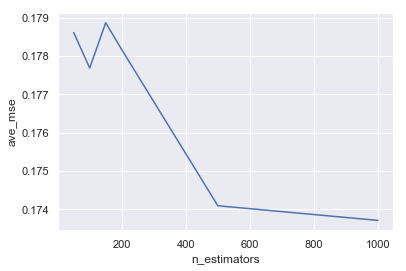

In [66]:
ax = sns.lineplot(x="n_estimators", y="ave_mse", data=pd.DataFrame({"n_estimators":best_est, "ave_mse":estimator_results}))

From the plot, we can see that setting n_estimators=500 will tend to improve the model and n_estimators>=600 will tend to overfit the data.

##### 2. Max_features
Random forest models randomly resample features prior to determining the best split. Max_features determines the number of features to resample. Larger max_feature values can result in improved model performance because trees have a larger selection of features from which choose the best split, but can also cause trees to be less diverse and induce overfitting. The common theme here is one needs to identify an optimal value that balances overfitting and under-fitting. Common choices include:
- ‘auto’: places no restrictions on the number of features,
- ‘sqrt’: square root of the total number of features,
- ‘log2’: base two logarithm of the total number of features.

In [80]:
maxFeature_results = []
best_maxFeature = []

for item in max_features:
    model = ExtraTreesRegressor(n_estimators=500, random_state=10, bootstrap=True, max_features=item)
    
    small_x_train = x_train[rfe_var[0:best_n_feature]]
    nested_result = []
    
    for k in range(repeat_kfold):
        train_df = pd.concat([small_x_train, y_train], axis=1, sort=False)
        train_df = shuffle(train_df)
        new_y = train_df['actual_depth']
        new_x = train_df.drop('actual_depth', axis=1)
        
        cv_results = cross_val_score(model, new_x, new_y, cv=set_cv, scoring=scoring)
#         print(cv_results)
        nested_result.append(-cv_results.mean())
        
        msg = "(k: {} -- max_features: {}) --> mean squared error: {}".format(k, item, -cv_results.mean())
        print(msg)
    
    maxFeature_results.append(sum(nested_result) / len(nested_result))
    best_maxFeature.append(item)

(k: 0 -- max_features: auto) --> mean squared error: 0.1768669158950802
(k: 1 -- max_features: auto) --> mean squared error: 0.17736188585521762
(k: 2 -- max_features: auto) --> mean squared error: 0.1720365733354555
(k: 3 -- max_features: auto) --> mean squared error: 0.17240300141297957
(k: 4 -- max_features: auto) --> mean squared error: 0.17355133721552415
(k: 0 -- max_features: sqrt) --> mean squared error: 0.3640976997815688
(k: 1 -- max_features: sqrt) --> mean squared error: 0.36288157636798535
(k: 2 -- max_features: sqrt) --> mean squared error: 0.37092037577458203
(k: 3 -- max_features: sqrt) --> mean squared error: 0.3695407357749383
(k: 4 -- max_features: sqrt) --> mean squared error: 0.36367997946666764
(k: 0 -- max_features: log2) --> mean squared error: 0.3794549327403282
(k: 1 -- max_features: log2) --> mean squared error: 0.38333665400887557
(k: 2 -- max_features: log2) --> mean squared error: 0.3833809461728865
(k: 3 -- max_features: log2) --> mean squared error: 0.38

In [81]:
pd.DataFrame({"max_features":best_maxFeature, "ave_mse":maxFeature_results})

,max_features,ave_mse
0,auto,0.174444
1,sqrt,0.366224
2,log2,0.382183


We keep max_features parameter at default value 'auto' as the others does help to improve the model.

##### 3. Max_depth
Each tree in the random forest model makes multiple splits to isolate homogeneous groups of outcomes. Larger numbers of splits allowed in each tree enables the trees to explain more variation in the data, however, trees with many splits may overfit the data. A range of depth values should be evaluated, including “None” where trees are split until all the leaves are pure

In [82]:
max_depth_results = []
best_max_depth = []

for num in max_depth:
    model = ExtraTreesRegressor(n_estimators=500, random_state=10, bootstrap=True, max_features='auto', max_depth=num)
    
    small_x_train = x_train[rfe_var[0:best_n_feature]]
    nested_result = []
    
    for k in range(repeat_kfold):
        train_df = pd.concat([small_x_train, y_train], axis=1, sort=False)
        train_df = shuffle(train_df)
        new_y = train_df['actual_depth']
        new_x = train_df.drop('actual_depth', axis=1)
        
        cv_results = cross_val_score(model, new_x, new_y, cv=set_cv, scoring=scoring)
#         print(cv_results)
        nested_result.append(-cv_results.mean())
        
        msg = "(k: {} -- max_depth: {}) --> mean squared error: {}".format(k, num, -cv_results.mean())
        print(msg)
    
    max_depth_results.append(sum(nested_result) / len(nested_result))
    best_max_depth.append(num)

(k: 0 -- max_depth: 10) --> mean squared error: 0.1796536502787662
(k: 1 -- max_depth: 10) --> mean squared error: 0.17805855882714475
(k: 2 -- max_depth: 10) --> mean squared error: 0.1744214422988067
(k: 3 -- max_depth: 10) --> mean squared error: 0.17198370403323085
(k: 4 -- max_depth: 10) --> mean squared error: 0.17817258594575658
(k: 0 -- max_depth: 20) --> mean squared error: 0.17504486971262342
(k: 1 -- max_depth: 20) --> mean squared error: 0.17519364248824107
(k: 2 -- max_depth: 20) --> mean squared error: 0.17223119473130943
(k: 3 -- max_depth: 20) --> mean squared error: 0.1731187181294265
(k: 4 -- max_depth: 20) --> mean squared error: 0.1746292933116906
(k: 0 -- max_depth: 30) --> mean squared error: 0.17535226936528966
(k: 1 -- max_depth: 30) --> mean squared error: 0.1755389421619975
(k: 2 -- max_depth: 30) --> mean squared error: 0.17463514258624613
(k: 3 -- max_depth: 30) --> mean squared error: 0.17585464944586904
(k: 4 -- max_depth: 30) --> mean squared error: 0.180

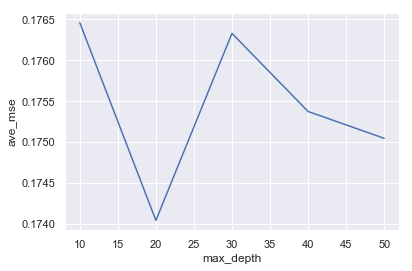

In [83]:
ax = sns.lineplot(x="max_depth", y="ave_mse", data=pd.DataFrame({"max_depth":best_max_depth, "ave_mse":max_depth_results}))

We can see that the best max_depth is 20

##### 4. min_samples_split
We can control the minimum number of samples required to split each node. Values too large may cause under-fitting, as the trees won’t be able to split enough times to achieve node purity. This hyperparameter should be based on the number of records in the training dataset.

In [84]:
min_split_results = []
best_min_split = []

for num in min_sample_split:
    model = ExtraTreesRegressor(n_estimators=500, random_state=10, bootstrap=True, max_features='auto', max_depth=20,
                               min_samples_split=num)
    
    small_x_train = x_train[rfe_var[0:best_n_feature]]
    nested_result = []
    
    for k in range(repeat_kfold):
        train_df = pd.concat([small_x_train, y_train], axis=1, sort=False)
        train_df = shuffle(train_df)
        new_y = train_df['actual_depth']
        new_x = train_df.drop('actual_depth', axis=1)
        
        cv_results = cross_val_score(model, new_x, new_y, cv=set_cv, scoring=scoring)
#         print(cv_results)
        nested_result.append(-cv_results.mean())
        
        msg = "(k: {} -- min_samples_split: {}) --> mean squared error: {}".format(k, num, -cv_results.mean())
        print(msg)
    
    min_split_results.append(sum(nested_result) / len(nested_result))
    best_min_split.append(num)

(k: 0 -- min_samples_split: 2) --> mean squared error: 0.177126999508025
(k: 1 -- min_samples_split: 2) --> mean squared error: 0.17515799842781485
(k: 2 -- min_samples_split: 2) --> mean squared error: 0.17594209652268492
(k: 3 -- min_samples_split: 2) --> mean squared error: 0.1719649632324782
(k: 4 -- min_samples_split: 2) --> mean squared error: 0.17463700094518464
(k: 0 -- min_samples_split: 5) --> mean squared error: 0.17739073837781016
(k: 1 -- min_samples_split: 5) --> mean squared error: 0.17471377275483238
(k: 2 -- min_samples_split: 5) --> mean squared error: 0.1752024074762202
(k: 3 -- min_samples_split: 5) --> mean squared error: 0.17339343751212655
(k: 4 -- min_samples_split: 5) --> mean squared error: 0.17333007759112903
(k: 0 -- min_samples_split: 10) --> mean squared error: 0.17902470097394996
(k: 1 -- min_samples_split: 10) --> mean squared error: 0.17645500707980263
(k: 2 -- min_samples_split: 10) --> mean squared error: 0.17687204795895364
(k: 3 -- min_samples_split

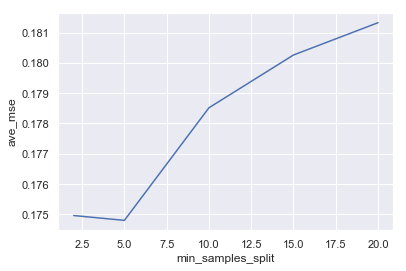

In [85]:
ax = sns.lineplot(x="min_samples_split", y="ave_mse", data=pd.DataFrame({"min_samples_split":best_min_split, "ave_mse":min_split_results}))

There is a slight improvement here, so we take optimal min_samples_split=5

##### 5. Min_samples_leaf
Much like stopping the growth of trees once a minimum number of samples per split is reached, we can set the minimum number of samples required for each leaf. With values too large, the trees may not be able to split enough to capture sufficient variation in the data. Optimal values for this hyperparameter are dependent on the size of the training set

In [86]:
min_leaf_results = []
best_min_leaf = []

for num in min_sample_leaf:
    model = ExtraTreesRegressor(n_estimators=500, random_state=10, bootstrap=True, max_features='auto', max_depth=20,
                               min_samples_split=5)
    
    small_x_train = x_train[rfe_var[0:best_n_feature]]
    nested_result = []
    
    for k in range(repeat_kfold):
        train_df = pd.concat([small_x_train, y_train], axis=1, sort=False)
        train_df = shuffle(train_df)
        new_y = train_df['actual_depth']
        new_x = train_df.drop('actual_depth', axis=1)
        
        cv_results = cross_val_score(model, new_x, new_y, cv=set_cv, scoring=scoring)
#         print(cv_results)
        nested_result.append(-cv_results.mean())
        
        msg = "(k: {} -- min_samples_leaf: {}) --> mean squared error: {}".format(k, num, -cv_results.mean())
        print(msg)
    
    min_leaf_results.append(sum(nested_result) / len(nested_result))
    best_min_leaf.append(num)

(k: 0 -- min_samples_leaf: 1) --> mean squared error: 0.18094210183287682
(k: 1 -- min_samples_leaf: 1) --> mean squared error: 0.17705455911269974
(k: 2 -- min_samples_leaf: 1) --> mean squared error: 0.17082656976244212
(k: 3 -- min_samples_leaf: 1) --> mean squared error: 0.1773564976883135
(k: 4 -- min_samples_leaf: 1) --> mean squared error: 0.17492870504255473
(k: 0 -- min_samples_leaf: 2) --> mean squared error: 0.1743715415031143
(k: 1 -- min_samples_leaf: 2) --> mean squared error: 0.17580493472411374
(k: 2 -- min_samples_leaf: 2) --> mean squared error: 0.1735874270092973
(k: 3 -- min_samples_leaf: 2) --> mean squared error: 0.17392273165427738
(k: 4 -- min_samples_leaf: 2) --> mean squared error: 0.17422900045967957
(k: 0 -- min_samples_leaf: 5) --> mean squared error: 0.17474307041650664
(k: 1 -- min_samples_leaf: 5) --> mean squared error: 0.17532647897372952
(k: 2 -- min_samples_leaf: 5) --> mean squared error: 0.17556653188299096
(k: 3 -- min_samples_leaf: 5) --> mean sq

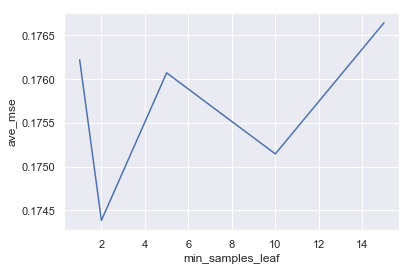

In [87]:
ax = sns.lineplot(x="min_samples_leaf", y="ave_mse", data=pd.DataFrame({"min_samples_leaf":best_min_leaf, "ave_mse":min_leaf_results}))

Finally, we find the best value for min_samples_leaf which is 2 (default value is 1). In the end, our final model with optimal parameter values is:

<b>model = ExtraTreesRegressor(n_estimators=500, 
    
                            random_state=10, 
                            
                            bootstrap=True, 
                            
                            max_features='auto', 
                            
                            max_depth=20, 
                            
                            min_samples_split=num)</b>